# Explainable AI with Synthetic Data

In this notebook, we demonstrate how a ML model, that was trained on real data, can be perfectly explored, reasoned around and validated in great detail with synthetic data. As synthetic data is not restricted by privacy, this allows to engage with far broader groups and communities, when it comes to algorithmic auditing, and ensuring the safety of developed ML-powered systems.

For further background see also [this blog post](https://mostly.ai/blog/the-future-of-explainable-ai-rests-upon-synthetic-data/) on "The Future of Explainable AI rests upon Synthetic Data".

## Train ML Model on Real Data

Let's again turn towards a trimmed down version of the UCI Adult [[1](#refs)] dataset, consisting of 10,000 records across a subset of 10 attributes.

In [1]:
# check whether we are in Google colab
try:
    from google.colab import files
    print("running in COLAB mode")
    is_colab = True
    repo = 'https://github.com/mostly-ai/mostly-tutorials/raw/dev/explainable-ai'
except:
    print("running in LOCAL mode")
    is_colab = False
    repo = '.'

running in LOCAL mode


In [2]:
# load original (real) data
import numpy as np
import pandas as pd
df = pd.read_csv(f'{repo}/census.csv')
df.head(5)

,age,education,marital_status,occupation,relationship,sex,capital_gain,capital_loss,hours_per_week,income
0,30,Bachelors,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,45,>50K
1,26,5th-6th,Married-civ-spouse,Craft-repair,Husband,Male,0,1628,50,<=50K
2,66,11th,Married-civ-spouse,Farming-fishing,Husband,Male,0,0,40,<=50K
3,17,11th,Never-married,Other-service,Other-relative,Female,0,0,22,<=50K
4,39,Doctorate,Married-civ-spouse,Prof-specialty,Husband,Male,0,0,50,>50K


In [3]:
import lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import train_test_split

target_col = 'income'
target_val = '>50K'

def prepare_xy(df):
    y = (df[target_col]==target_val).astype(int)
    str_cols = [col for col in df.select_dtypes(['object', 'string']).columns if col != target_col]
    for col in str_cols:
        df[col] = pd.Categorical(df[col])
    cat_cols = [col for col in df.select_dtypes('category').columns if col != target_col]
    num_cols = [col for col in df.select_dtypes('number').columns if col != target_col]
    for col in num_cols:
        df[col] = df[col].astype('float')
    X = df[cat_cols + num_cols]
    return X, y

def train_model(X, y):
    cat_cols = list(X.select_dtypes('category').columns)
    X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
    ds_trn = lgb.Dataset(X_trn, label=y_trn, categorical_feature=cat_cols, free_raw_data=False)
    ds_val = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_cols, free_raw_data=False)
    model = lgb.train(
        params={
            'verbose': -1,
            'metric': 'auc',  
            'objective': 'binary'
        }, 
        train_set=ds_trn,
        valid_sets=[ds_val],
        callbacks=[early_stopping(5)],
    )
    return model

import warnings
warnings.filterwarnings('ignore')

In [4]:
X, y = prepare_xy(df)
model = train_model(X, y)

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[63]	valid_0's auc: 0.917156


## Synthesize Data via MOSTLY AI

1. Download `census.csv` by clicking [here](https://github.com/mostly-ai/mostly-tutorials/raw/dev/explainable-ai/census.csv), and then press Ctrl+S to save the file locally.

2. Synthesize `census.csv` via [MOSTLY AI](https://mostly.ai/), leaving all defaults as-is

3. Once the job has finished, download the generated synthetic data as CSV file to your computer.

4. Upload the generated synthetic data to this Notebook via executing the next cell.

In [5]:
# upload synthetic dataset
if is_colab:
    import io
    uploaded = files.upload()
    syn = pd.read_csv(io.BytesIO(list(uploaded.values())[0]))
    print(f"uploaded synthetic data with {syn.shape[0]:,} records and {syn.shape[1]:,} attributes")
else:
    syn_file_path = './census-synthetic.csv'
    syn = pd.read_csv(syn_file_path)
    print(f"read synthetic data with {syn.shape[0]:,} records and {syn.shape[1]:,} attributes")

read synthetic data with 10,000 records and 10 attributes


## Evaluate ML Performance on Synthetic

This is also known as a Train-Real-Test-Synthetic (TRTS) approach.

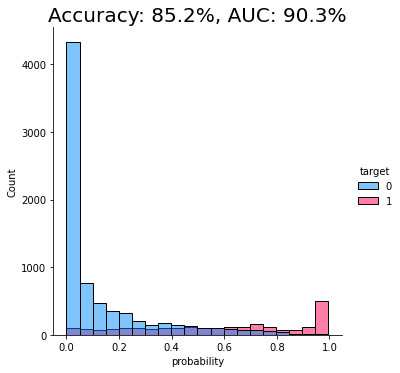

In [6]:
from sklearn.metrics import roc_auc_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

X_syn, y_syn = prepare_xy(syn)
p_syn = model.predict(X_syn)
auc = roc_auc_score(y_syn, p_syn)
acc = accuracy_score(y_syn, (p_syn >= 0.5).astype(int))
probs_df = pd.concat([
    pd.Series(p_syn, name='probability').reset_index(drop=True),
    pd.Series(y_syn, name='target').reset_index(drop=True),
], axis=1)
fig = sns.displot(data=probs_df, x='probability', hue='target', bins=20, palette=['#008CFB', '#FF004F'])
fig = plt.title(f"Accuracy: {acc:.1%}, AUC: {auc:.1%}", fontsize=20)
plt.show()

## Explain ML Model with Synthetic

We will be using the **SHAP library**, a state-of-the-art Python package for Explainable AI. Learn more about SHAP and XAI at https://shap-lrjball.readthedocs.io/ and https://christophm.github.io/interpretable-ml-book/.

In [7]:
# install required Python packages
!pip install -q shap

### Calculate SHAP values for trained model w/ synthetic data

Important: For this step no access to the original (privacy-sensitive) training data is needed anymore. We only need access to the trained model for inference, as well as to representative synthetic data.

In [8]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_syn)

### SHAP Feature Importance

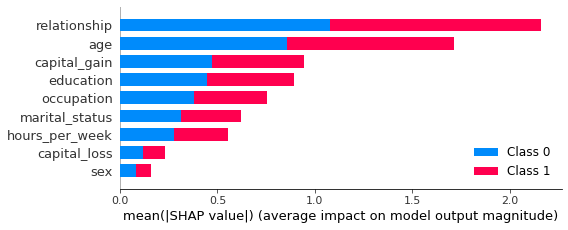

In [9]:
shap.initjs()
shap.summary_plot(shap_values, X_syn, plot_size=0.2)

### SHAP Dependency Plots

Let's study the value-dependent impact of each model feature. SHAP dependency plots are a great way to do so, as they not only show the average lift, but also the level of variance of that lift, at the same time.

In [10]:
def plot_shap_dependency(col):
    col_idx = [i for i in range(X_syn.shape[1]) if X_syn.columns[i]==col][0]
    shp_vals = pd.Series(shap_values[1][:,col_idx], name='shap_value')
    col_vals = X_syn.iloc[:,col_idx].reset_index(drop=True)
    df = pd.concat([shp_vals, col_vals], axis=1)
    if col_vals.dtype.name != 'category':
        q01 = df[col].quantile(0.01)
        q99 = df[col].quantile(0.99)
        df = df.loc[(df[col] >= q01) & (df[col] <= q99), :]
    else:
        sorted_cats = list(df.groupby(col)['shap_value'].mean().sort_values().index)
        df[col] = df[col].cat.reorder_categories(sorted_cats, ordered=True)
    fig, ax = plt.subplots(figsize=(8, 4))
    plt.ylim(-3.2, 3.2)
    plt.title(col)
    plt.xlabel('')
    if col_vals.dtype.name == 'category':
        plt.xticks(rotation = 90)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.tick_params(axis='both', which='minor', labelsize=6)
    p1 = sns.lineplot(x=df[col], y=df['shap_value'], color='black').axhline(0, color='gray', alpha=1, lw=0.5)
    p2 = sns.scatterplot(x=df[col], y=df['shap_value'], alpha=0.1)
    
def plot_shap_dependencies():
    top_features = list(reversed(X_syn.columns[np.argsort(np.mean(np.abs(shap_values[1]), axis=0))]))
    for col in top_features:
        plot_shap_dependency(col)

plot_shap_dependencies()

### SHAP Values for Single (Synthetic) Samples

Let's study the factors behind the model scores by inspecting individual samples. Note, that this level of reasoning at an individual-level would not be possible with real data, if that consists of privacy-sensitive information. However, synthetic data allows to reason around samples at any scale.

In [11]:
def show_idx(i):
    shap.initjs()
    df = X_syn.iloc[i:i+1, :]
    df.insert(0, 'actual', y_syn.iloc[i])
    df.insert(1, 'score', p_syn[i])
    display(df)
    return shap.force_plot(explainer.expected_value[1], shap_values[1][i,:], X_syn.iloc[i,:], link="logit")

#### Random Sample

In [12]:
rnd_idx = X_syn.sample().index[0]
show_idx(rnd_idx)

,actual,score,education,marital_status,occupation,relationship,sex,age,capital_gain,capital_loss,hours_per_week
3805,0,0.069231,Bachelors,Never-married,Sales,Not-in-family,Female,28.0,0.0,2000.0,58.0


#### Sample with lowest score

In [13]:
idx = np.argsort(p_syn)[0]
show_idx(idx)

,actual,score,education,marital_status,occupation,relationship,sex,age,capital_gain,capital_loss,hours_per_week
6050,0,0.000568,12th,Never-married,Sales,Own-child,Male,18.0,0.0,0.0,35.0


#### Sample with highest score

In [14]:
idx = np.argsort(p_syn)[-1]
show_idx(idx)

,actual,score,education,marital_status,occupation,relationship,sex,age,capital_gain,capital_loss,hours_per_week
6046,1,0.996429,Bachelors,Married-civ-spouse,Tech-support,Husband,Male,37.0,15024.0,0.0,40.0


#### Sample with a median score

In [15]:
idx = np.argsort(p_syn)[int(len(p_syn)/2)]
show_idx(idx)

,actual,score,education,marital_status,occupation,relationship,sex,age,capital_gain,capital_loss,hours_per_week
718,0,0.079717,Some-college,Married-civ-spouse,Exec-managerial,Husband,Male,69.0,5013.0,0.0,45.0


#### Sample a young Female Doctor

In [16]:
idx = syn[(syn.education=='Doctorate') & (syn.sex=='Female') & (syn.age<=30)].sample().index[0]
show_idx(idx)

,actual,score,education,marital_status,occupation,relationship,sex,age,capital_gain,capital_loss,hours_per_week
9728,0,0.07314,Doctorate,Never-married,Prof-specialty,Not-in-family,Female,25.0,0.0,0.0,40.0


### Explore SHAP Values across a thousand samples

In [17]:
shap.force_plot(explainer.expected_value[1], shap_values[1][:1000,:], X.iloc[:1000,:], link="logit")

## Conclusion

This tutorial demonstrated how ML models, that have been trained on real data, can be safely tested and explained with synthetic data. As the latter is not privacy-sensitive, this allows to have these types of introspections and validations performed by a significantly larger group of stakeholders. This is a key part to build safe & smart algorithms, that will have a significant impact on individuals' lives.

## Further exercises

In addition to walking through the above instructions, we suggest..
* replicating the explainability section with real data and compare results
* using a different dataset, eg. the UCI bank-marketing dataset [[2](#refs)]
* using a different ML model, eg. a RandomForest model [[3](#refs)]

## References<a class="anchor" name="refs"></a>

1. https://archive.ics.uci.edu/ml/datasets/adult
1. https://archive.ics.uci.edu/ml/datasets/bank+marketing
1. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html